# Phase 2: Deriving value from Customer Analytics - Churn analysis

##### Table of content:
1. [Data preparation for survival analysis](#part1)
2. [Survival modelling](#part2)
3. [Conclusion](#part3)

## <font color='blue'>Introduction</font>

In the prior analysis, the Olist customers were segmented and their customer life time value was calculated. This enables Olist to identify their best customers. If these customers were to leave Olist and become a customer in one of Olist competitors then it would hurt Olist revenue. Therefore, it is relevant to conduct a churn analysis in order to identify which customers might churn in the future. Knowing this, Olist can take actions specifik againt the customer likely to churn to keep the customer.



In the following notebook a churn analysis will be carried out. The churn analysis employs survival analysis to predict whether a customer will churn or not. Survival analysis has been chosen because besides giving an idea if a customer is going to stop doing business it also gives a probability for when the event might happen. 







## <font color='blue'>Setup 1</font>: Load Libraries

In [7]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

The customer data sets are loaded as in the previous notebook which include Olist_customers,Olist_orders and Olist_order_payments. Futhermore, the order item dataset is joined with the customer data since it could be relevant to use features such as product category for later modelling in the prediction model.

## <font color='blue'>Setup 2</font>: Load data

In [8]:
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")
orders_item = pd.read_csv(dirpath+"olist_order_items_dataset.csv")
products = pd.read_csv(dirpath+"olist_products_dataset.csv")
reviews = pd.read_csv(dirpath+"olist_order_reviews_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')
cop = cop.merge(orders_item, on='order_id', how='left')
cop = cop.merge(products, on='product_id', how='left')
cop = cop.merge(reviews, on='order_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

In [9]:
cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,8683.0,54.0,64.0,31.0,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,10150.0,89.0,15.0,40.0,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,8267.0,52.0,52.0,17.0,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,12160.0,56.0,51.0,28.0,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,5200.0,45.0,15.0,35.0,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52


## <font color='blue'>Part 1</font>: Data preparation for survival analysis
<a id=part1></a>

In survival analysis, a data point is characterised by three elements: $X_i,E_i,T_i, \forall i \in N$ where $N$ is number of datapoints. 

- $X_i$ : is a p-dimensional feature vector
- $E_i$ : is an event indicator. If $E_i = 1$ an event happens, the other case where $E_i=0$ means that the data point is censored because an event does not happen. 
- $T_i$ : $min(t_i,c_i)$ , where $t_i$ is the actual time to event and $c_i$ is time to censoring


Survival data involves modelling time to an event happens. The time to event involves the duration between a birth and a death. In this case a birth happens every time a customer buys something from Olist. The birth starts a process and two things can happen from here. Either the customer buys another thing through Olist, which causes the process to die because an event happens but also a new birth process will start. The other thing that can happen is that after the customer buys from Olist and the birth process has started then the customer does not return to buy anything from Olist so no event happens - which we saw is the most frequent case in the previous notebook about segmentation and Customer Lifetime Value. If the customer does not buy anything again then the process will be censored. Censoring an observation means we do not know if and when an event will happen for this observation.
Survival function, S(t) is the probability that the event of interest has not occured by some time $t$.
$S(t) = 1 - F(t) = Pr[T\leq t]$

The process is visuliased in the figure below. We are considering three customers {A,B,C}. Customer B buys from Olist on the 09/04/2016, as the first customer in our dataset, so a birth process starts. The process is continuing all the way up til the red point where an Event happens because Customer B buys another thing from Olist and thereby the process stops because it dies with an event. Customer C on the other hand buys from Olist but does not buy again in the time horizon for our dataset. Thus Customer C's survival time is longer than the time of our study. We cannot say whether Customer C will experience an Event or not - only that it does not happen in our time frame. 
Customer A is the same as B except that Customer A first becomes a customer at Olist at some point in Time after Customer B but is undergoing the same type of process as Customer B.

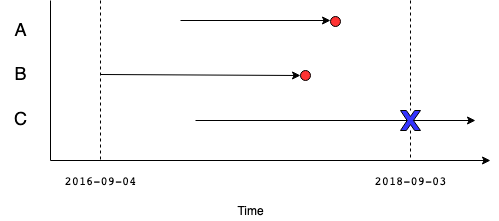

In the following section, the data will be preprocessed to be ready for modelling with survival models:

1. An Event and Time column will be calculated
2. Features that will be included in the survival analysis will be identified and presented

In [10]:
# Creating a column "number of purchases" and joining it on
df = cop.merge(cop.groupby('customer_unique_id').size().reset_index(), on='customer_unique_id', how='left')

# Getting last date of purchase
t_end = cop.order_purchase_timestamp.max()

# Separating customers with multiple purchases from customers with a single purchase 
df_event_1 = df[df.iloc[:,-1] > 1]
df_event_0 = df[df.iloc[:,-1] < 2]

In [5]:
# Calculating the difference between purchasedates (in weeks) of first and following orders of the same customer.   
df_event_1 = df_event_1.groupby('customer_unique_id')['order_purchase_timestamp'].apply(lambda x: x.sort_values()).reset_index()
df_event_1['T'] = (df_event_1.groupby('customer_unique_id')['order_purchase_timestamp'].diff() / np.timedelta64(1, 'W'))
# Removing a customers first purchase from dataframe
df_event_1 = df_event_1.dropna(subset=['T'])
# Rounding up number of weeks
df_event_1['T'] = df_event_1['T'].apply(np.ceil).astype(int)
# Removing purchases with same purchase date and time for a given customers.
df_event_1 = df_event_1[df_event_1['T'] > 0]
# Setting event variable to one
df_event_1['E'] = 1
df_event_1 = df_event_1[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [6]:
df_event_1.head()

,customer_unique_id,order_purchase_timestamp,T,E
31,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,25,1
35,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,39,1
67,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,1
87,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,1,1
115,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,9,1


In [7]:
df_event_0['E'] = 0
df_event_0['T'] = ((t_end - df_event_0.order_purchase_timestamp) / np.timedelta64(1, 'W')).apply(np.ceil).astype(int)
df_event_0 = df_event_0[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [8]:
# Subsetting data
df_event_0 = df_event_0.sample(16000, replace=True)
#df_event_0 = df_event_0[:16000]

Now that the event and time column has been defined, features for the modelling are going to be selected. 
Often customers tend to complain about the shipping time for the product they have ordered.
This is modelled as a category variabel, if the estimated delivery date is larger or equal than the actual delivered date then 1 else 0.

In [9]:
# Feature: on time shipping
cop['on_time_delivery'] = (cop.order_delivered_customer_date <= cop.order_estimated_delivery_date).astype(int)
#df_model['on_time_delivery'].value_counts()

In [10]:
# Feature: product price category
#cat_prices = cop.groupby(['product_category_name']).mean()['price'].sort_values()
#q33, q66 = np.quantile(cat_prices, q=[.33,.66])

#cop['product_price_cat'] = 'Low-price'
#cop.loc[cop['price']>q33,'product_price_cat'] = 'Mid-price' 
#cop.loc[cop['price']>q66,'product_price_cat'] = 'High-price' 

Furthermore, the shipping price can also effect customers on the purchase behavior. High shipping prices could potentially scare customers away. Therefore, Freight_value is also included as a feature.

Now with the chosen features, the final dataset is made. 

In [11]:
# Concatenating data
df_event = pd.concat([df_event_1, df_event_0])

# Joining features on
df_full = df_event.merge(cop, on=['customer_unique_id','order_purchase_timestamp'], how='left')

df_model = df_full[['T','E','customer_state','payment_value','review_score','on_time_delivery','freight_value']]

# One-hot encoding categorical features
df_model = pd.get_dummies(data=df_model, columns=['customer_state'])

# Drop null
df_model = df_model.dropna()

In [12]:
df_model.head()

,T,E,payment_value,review_score,on_time_delivery,freight_value,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
0,25,1,103.28,5,1,15.38,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,39,1,49.85,5,1,22.85,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,26.78,4,1,15.23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,81.78,5,1,11.88,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,81.78,3,1,11.88,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


The distribution of the customers who churned/not-churned are shown below.

In [13]:
df_full.E.value_counts()

0    16000
1     3841
Name: E, dtype: int64

The data is checked for Null values and and duplicates

In [14]:
N_null = sum(df_model.isnull().sum())
N_dupli = sum(df_model.duplicated(keep='first'))
print('The raw_dataset contains {} null values.'.format(N_null))
print('The dataset contains {} duplicates.'.format(N_dupli))

The raw_dataset contains 0 null values.
The dataset contains 2252 duplicates.


As a final step in the data preparation, the data is standardised by subtracting the mean and dividing with the std.

In [15]:
mu = df_model.payment_value.mean()
sigma = df_model.payment_value.std()
df_model.payment_value = (df_model.payment_value - mu)/sigma # standardization of data
df_model = df_model.dropna()

It is relevant to see the correlation between the chosen features. This can be done through pysurvivals correlation_matrix function.

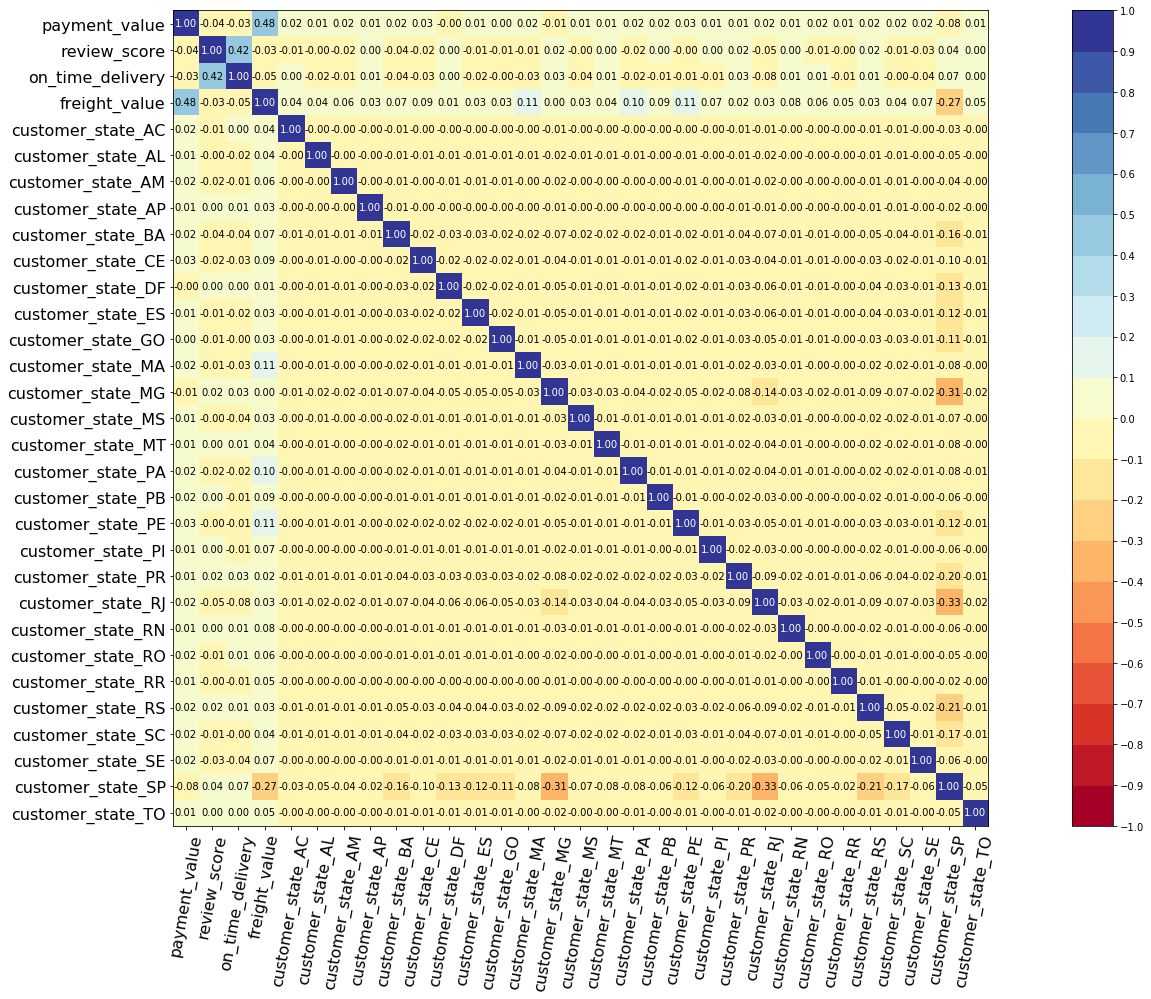

In [16]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(df_model.iloc[:,2:], figure_size=(30, 15), text_fontsize=10)

The correlations are not that high. The higest correlation found is between payment_value and feight_value on 0.48. Furthermore, Review_score and on_time_delivery is also correlated with 0.42. This also makes good sense because customers would give higher ratings if their product is delivered on time - and the other way around.

## <font color='blue'>Part 2</font>: Survival modelling
<a id=part2></a>

The data is splitted into a train and test set.

In [17]:
from sklearn.model_selection import train_test_split
time_column = 'T'
event_column = 'E'

N = df_model.shape[0]

index_train, index_test = train_test_split(range(N), test_size = 0.35)
df_model = df_model.reset_index()
data_train = df_model.loc[index_train].reset_index( drop = True )
data_test  = df_model.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train.iloc[:,2:], data_test.iloc[:,2:]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [18]:
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.metrics import concordance_index

First a Kaplan-Meier (KM) model is fitted to the data. This "simple" model will act as baseline for comparison to a more advanced model later.
The KM-model is only fittet on the time and event column.

In [70]:
import lifelines
from lifelines import KaplanMeierFitter
km = KaplanMeierFitter()
km.fit(
    df_model[time_column],
    event_observed=df_model[event_column])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 19714 total observations, 15891 right-censored observations>

In [71]:
S = km.survival_function_.to_numpy().flatten()

A Conditional survival tree model is fitted to the data. The model is an alternative survival model which is built on the machine learning algorithm, random forest. 

The number of trees could have been tuned using grid search. This have not been done in this notebook, however different values where tested and evaluated with c-index. 

In [73]:
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel
xst = ExtraSurvivalTreesModel(num_trees=80) 
xst.fit(X_train, T_train, E_train,
        max_features='sqrt',
        max_depth=5,
        min_node_size=20,
        num_random_splits=20)

ExtraSurvivalTreesModel

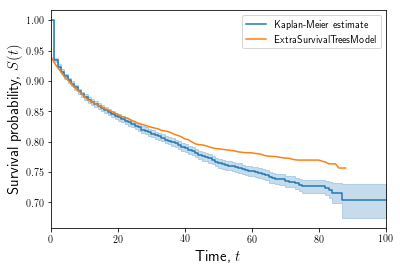

In [68]:
# Plot KM estimate of the survival function
plt.rc('text', usetex=True)

# Display survival function
ax = km.plot(label='Kaplan-Meier estimate')
ax.set_xlabel(
    'Time, $ t $',
    fontsize=15.,
)
ax.set_ylabel(
    'Survival probability, $ S(t) $',
    
    fontsize=15.,
)

plt.plot(xst.predict_survival(X_test.mean()).flatten(),
            label=' ExtraSurvivalTreesModel',
)

plt.legend()
plt.show()

To assess the performance of the model, the C-index can be used. This represents a global assessment of the model descrimination. A low C-value indicates that the model is does not provide a reliable ranking of the survival times - whereas a high score means that the model is able to discriminate between the individuals. 
The c-score is given by the following formula:
$$ C = \frac{1}{\vert \epsilon \vert} \sum_{i: E_i = 1} \sum_{j: t_j \ge t_i} \mathbf{1}_{f(\mathrm{\mathbf{x}}_i) < f(\mathrm{\mathbf{x}}_j)} $$

where $ \epsilon $ is the number of samples and $ \mathbf{1} $ is the indicator function with binary outcome based on the condition.

In [20]:
print('Model name: {}'.format(xst.name))
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(xst, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(xst, X_test, T_test, E_test)))

Model name: ExtraSurvivalTreesModel
C-index: 0.962
C-index: 0.961


The C-score gives a value of 0.961 for our test data. Thus, our model has a quite high discrimination power.


## <font color='blue'>Conclusion</font>
<a id=part3></a>
The object with this analysis was to implement a model that could predict whether Olist customers would _churn/not churn_ using survival analysis. By implementing a Conditional survival tree model, a very high performning model is found which is relaible to discriminate between low risk and high risk individuals.

This model can potentially bring a lot of value to Olist. From the previous notebook, a segmentation and Customer-lifetime-value analysis was conducted which enabled Olist to identify their best customers. 
With the Churn prediction model, Olist can monitor the probability for customers churning. If a customer's probability for churning is high then Olist can take preventive actions such as a special offer or other incentives which would keep the customers. 